## Install ffmpeg in anaconda to run the animation.

In [1]:
import numpy as np
from scipy import integrate
from matplotlib import cm
from matplotlib import animation
import matplotlib.pyplot as plt

In [2]:
#Set number of elements, final time and dt
N=99
Tf = 10
dt = 0.005
Nt = int(np.ceil(Tf/dt))
b=1
a=0
h = (b-a)/(N+1)

In [3]:
def M(N):
    A = (np.diag([2/3 for i in range(N)],0)+np.diag([1/6 for i in range(N-1)],-1)+np.diag([1/6 for i in range(N-1)],1))
    return h*A

In [4]:
def A(N):
    B = (np.diag([2 for i in range(N)],0)+np.diag([-1 for i in range(N-1)],-1)+np.diag([-1 for i in range(N-1)],1))
    return 1/h*B

In [5]:
#Create finite element approximation of function.
def Initial_pos(N,b,a,f):
    h = (b-a)/(N+1)
    def f_1(x,f,begin):
        return 1/h**2*f(x)*(x-begin)
    def f_2(x,f,end):
        return 1/h**2*f(x)*(end-x)
    pos = np.linspace(a,b,N+2)
    Init = np.zeros(N+2)
    for i in range(1,N+1):
        dx1 = np.linspace(pos[i-1],pos[i],1001)
        dx2 = np.linspace(pos[i],pos[i+1],1001)
        Init[i] = integrate.simpson(f_1(dx1,f,pos[i-1]),dx1)+integrate.simpson(f_2(dx2,f,pos[i+1]),dx2)
    return Init

In [6]:
#Define initial conditions
f = lambda x: 1*np.sin(2*np.pi*x/(b-a))
f4 = lambda x: 10*np.cos(4*np.pi*x/(b-a))
f2 = lambda x: 0 #np.sin(2*np.pi*x/(b-a))
f3 = lambda x: 1*(x-a)*(x-b)*(x-(b+a)/2)

In [7]:
u_0 = Initial_pos(N,b,a,f)[1:-1]

In [8]:
u_1 = u_0 +dt*Initial_pos(N,b,a,f4)[1:-1]
u_2 = 2*u_1-u_0+dt**2*Initial_pos(N,b,a,f2)[1:-1]
u_3 = 3*u_2-3*u_1+u_0+dt**3*Initial_pos(N,b,a,f2)[1:-1]

In [9]:
#Set epsilon value and p value
epsilon = 0.01*dt
p=6
u_perturbed = np.zeros([N,Nt])
u_perturbed[:,0] = u_0
u_perturbed[:,1] = u_1
u_perturbed[:,2] = u_2
u_perturbed[:,3] = u_3

In [10]:
#Non-pertubed solver
u = np.zeros([N,Nt])
u[:,0] = u_0
u[:,1] = u_1
LEFT = M(N)+dt**2*A(N)
for i in range(2,Nt):
    RIGHT = 2*M(N)@u[:,i-1]-M(N)@u[:,i-2]-dt**2*p/2*u[:,i-1]**(p-1)
    x = np.linalg.solve(LEFT,RIGHT)
    u[:,i] = x

In [11]:
M_inv =np.linalg.inv(M(N))

for j in range(4,Nt):
    RIGHT = (4*(epsilon/dt)-2)*(epsilon/dt-1)*M(N)@u_perturbed[:,j-1] - \
    (6*(epsilon/dt)**2-6*(epsilon/dt)+1)*M(N)@u_perturbed[:,j-2] +\
    2*(epsilon/dt)*(2*(epsilon/dt)-1)*M(N)@u_perturbed[:,j-3] -\
    (epsilon/dt)**2*M(N)@u_perturbed[:,j-4]\
    -dt**2*p/2*u_perturbed[:,j-1]**(p-1)
    LEFT = ((epsilon/dt)-1)**2*M(N)+dt**2*A(N)
    x = np.linalg.solve(LEFT,RIGHT)
    u_perturbed[:,j] = x

In [12]:
print("dt={}, eps={}".format(dt,epsilon))

dt=0.005, eps=5e-05


In [13]:
def true_sol(x,t):
    return 1/2*np.sin(2*np.pi*x)*np.cos(2*np.pi*t)

In [17]:
fig = plt.figure(figsize = (6,4), dpi=150)
ax = plt.axes()
f_stride = 5
ims = [None for i in range(int(Nt/f_stride))]
#plt.plot(x_plot,rho_inf_vals,color='r')
for l in range(int(Nt/f_stride)):
    im, = ax.plot(np.linspace(a,b,N+2),np.concatenate([[0],u[:,int(f_stride*l)],[0]]),color='b',label=r'$\epsilon=0$')
    #im4, = ax.plot(np.linspace(a,b,N+2),np.concatenate([[0],u_lin[:,int(f_stride*l)],[0]]),color='k',label='linear sol')
    #im2, = ax.plot(np.linspace(a,b,N+2),np.concatenate([[0],u_perturbed2[:,int(f_stride*l)],[0]]),color='k',label=r'$\frac{\epsilon}{\tau}=0.1$',alpha=1) 
    im3, = ax.plot(np.linspace(a,b,N+2),np.concatenate([[0],u_perturbed[:,int(f_stride*l)],[0]]),color='g',label=r'$\frac{\epsilon}{\tau}=0.01$',alpha=1)
    #im4, = ax.plot(np.linspace(a,b,N+2),np.concatenate([[0],u_perturbed3[:,int(f_stride*l)],[0]]),color='r',label=r'$\frac{\epsilon}{\tau}=0.001$',alpha=1) 
    #im5, = ax.plot(np.linspace(a,b,N+2),np.concatenate([[0],u_perturbed4[:,int(f_stride*l)],[0]]),color='m',label=r'$\frac{\epsilon}{\tau}=0.3$',alpha=1)
    title = ax.text(0.45,-0.75, "t={}".format('%s' % float(str('%s' % float('%.2g' % float(f_stride*l*dt)))[:4])))
    title2 = ax.text(0.25,-1.8, "$u_0=\sin(2\pi x),\: u_0'=10\cos(4\pi x)$")
    title3 = ax.text(0.35,1.5, r"$\frac{\partial^2 u}{\partial t^2}-\frac{\partial^2 u}{\partial x^2}+3u^5=0$",size=12)
    ims[l] = [im,im3,title,title2,title3]
#plt.grid()

plt.rcParams["animation.html"]= 'html5'
plt.title(r"$\tau={}, h={}, \epsilon/\tau={}$".format(dt,h,epsilon/dt))
plt.ylim([-2,2])
ax.legend(handles=[im,im3],loc='upper right')
ani = animation.ArtistAnimation(fig,ims,interval = 100)
#plt.legend(loc='upper right')
plt.ylabel("u")
plt.xlabel("x")
plt.close()

In [18]:
ani

Text(0.5, 0.98, "IMEX algorithm: $\\frac{\\partial^2 u}{\\partial t^2}-\\frac{\\partial^2 u}{\\partial x^2}+3u^5=0$, $\\epsilon/\\tau$=0.01\n h=0.01,$\\tau=0.005$\nT=9, b-a=1\n$u_0=\\sin(2\\pi x),\\: u_0'=10\\cos(4\\pi x)$")

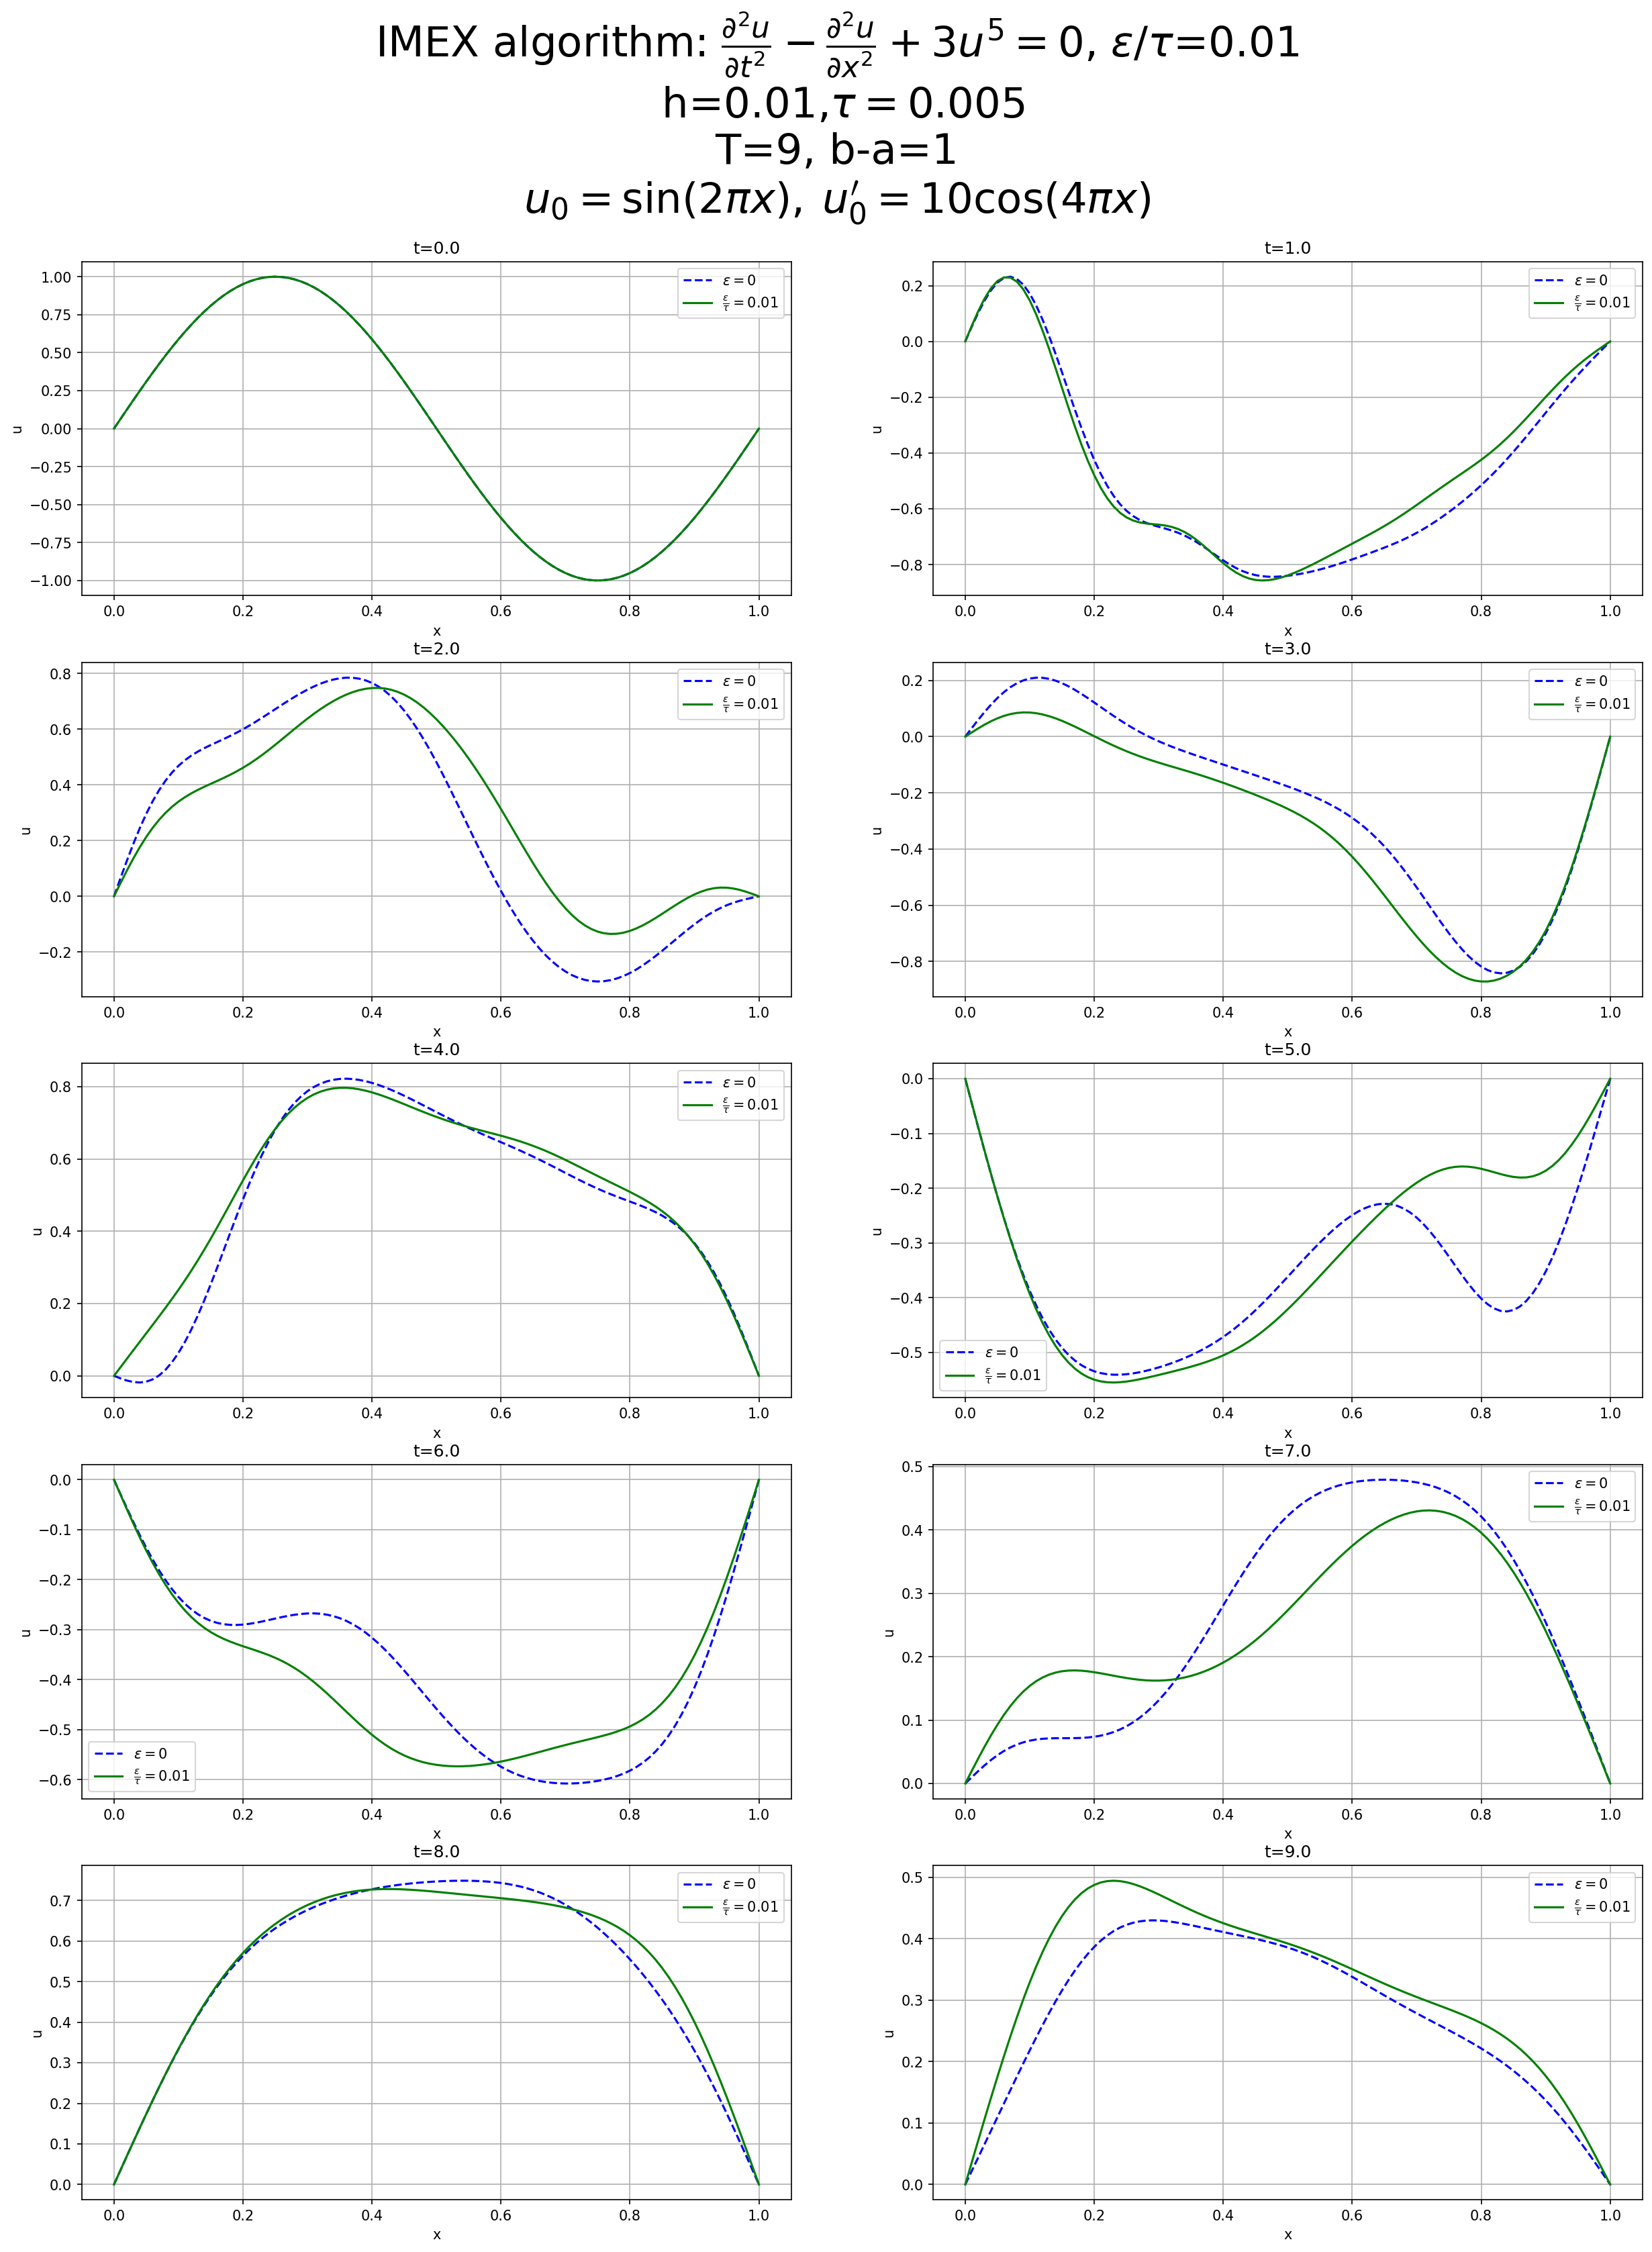

In [19]:
fig,axs = plt.subplots(5,2,figsize=(20,25),dpi=150)

stride = Nt/Tf

axs[0,0].plot(np.linspace(a,b,N+2),np.concatenate([[0],u[:,int(stride*0)],[0]]),color='b',label=r'$\epsilon=0$',linestyle='--')
axs[0,0].plot(np.linspace(a,b,N+2),np.concatenate([[0],u_perturbed[:,int(stride*0)],[0]]),color='g',label=r'$\frac{\epsilon}{\tau}=0.01$',alpha=1)
axs[0,1].plot(np.linspace(a,b,N+2),np.concatenate([[0],u[:,int(stride*1)],[0]]),color='b',label=r'$\epsilon=0$',linestyle='--')
axs[0,1].plot(np.linspace(a,b,N+2),np.concatenate([[0],u_perturbed[:,int(stride*1)],[0]]),color='g',label=r'$\frac{\epsilon}{\tau}=0.01$',alpha=1)
axs[1,0].plot(np.linspace(a,b,N+2),np.concatenate([[0],u[:,int(stride*2)],[0]]),color='b',label=r'$\epsilon=0$',linestyle='--')
axs[1,0].plot(np.linspace(a,b,N+2),np.concatenate([[0],u_perturbed[:,int(stride*2)],[0]]),color='g',label=r'$\frac{\epsilon}{\tau}=0.01$',alpha=1)
axs[1,1].plot(np.linspace(a,b,N+2),np.concatenate([[0],u[:,int(stride*3)],[0]]),color='b',label=r'$\epsilon=0$',linestyle='--')
axs[1,1].plot(np.linspace(a,b,N+2),np.concatenate([[0],u_perturbed[:,int(stride*3)],[0]]),color='g',label=r'$\frac{\epsilon}{\tau}=0.01$',alpha=1)
axs[2,0].plot(np.linspace(a,b,N+2),np.concatenate([[0],u[:,int(stride*4)],[0]]),color='b',label=r'$\epsilon=0$',linestyle='--')
axs[2,0].plot(np.linspace(a,b,N+2),np.concatenate([[0],u_perturbed[:,int(stride*4)],[0]]),color='g',label=r'$\frac{\epsilon}{\tau}=0.01$',alpha=1)
axs[2,1].plot(np.linspace(a,b,N+2),np.concatenate([[0],u[:,int(stride*5)],[0]]),color='b',label=r'$\epsilon=0$',linestyle='--')
axs[2,1].plot(np.linspace(a,b,N+2),np.concatenate([[0],u_perturbed[:,int(stride*5)],[0]]),color='g',label=r'$\frac{\epsilon}{\tau}=0.01$',alpha=1)
axs[3,0].plot(np.linspace(a,b,N+2),np.concatenate([[0],u[:,int(stride*6)],[0]]),color='b',label=r'$\epsilon=0$',linestyle='--')
axs[3,0].plot(np.linspace(a,b,N+2),np.concatenate([[0],u_perturbed[:,int(stride*6)],[0]]),color='g',label=r'$\frac{\epsilon}{\tau}=0.01$',alpha=1)
axs[3,1].plot(np.linspace(a,b,N+2),np.concatenate([[0],u[:,int(stride*7)],[0]]),color='b',label=r'$\epsilon=0$',linestyle='--')
axs[3,1].plot(np.linspace(a,b,N+2),np.concatenate([[0],u_perturbed[:,int(stride*7)],[0]]),color='g',label=r'$\frac{\epsilon}{\tau}=0.01$',alpha=1)
axs[4,0].plot(np.linspace(a,b,N+2),np.concatenate([[0],u[:,int(stride*8)],[0]]),color='b',label=r'$\epsilon=0$',linestyle='--')
axs[4,0].plot(np.linspace(a,b,N+2),np.concatenate([[0],u_perturbed[:,int(stride*8)],[0]]),color='g',label=r'$\frac{\epsilon}{\tau}=0.01$',alpha=1)
axs[4,1].plot(np.linspace(a,b,N+2),np.concatenate([[0],u[:,int(stride*9)],[0]]),color='b',label=r'$\epsilon=0$',linestyle='--')
axs[4,1].plot(np.linspace(a,b,N+2),np.concatenate([[0],u_perturbed[:,int(stride*9)],[0]]),color='g',label=r'$\frac{\epsilon}{\tau}=0.01$',alpha=1)

axs[0,0].set_title("t={}".format(0*stride/Nt*Tf))
axs[0,1].set_title("t={}".format(1*stride/Nt*Tf))
axs[1,0].set_title("t={}".format(2*stride/Nt*Tf))
axs[1,1].set_title("t={}".format(3*stride/Nt*Tf))
axs[2,0].set_title("t={}".format(4*stride/Nt*Tf))
axs[2,1].set_title("t={}".format(5*stride/Nt*Tf))
axs[3,0].set_title("t={}".format(6*stride/Nt*Tf))
axs[3,1].set_title("t={}".format(7*stride/Nt*Tf))
axs[4,0].set_title("t={}".format(8*stride/Nt*Tf))
axs[4,1].set_title("t={}".format(9*stride/Nt*Tf))


for ax in axs.flat:
    ax.set(xlabel='x',ylabel='u')
    ax.grid()
    ax.legend()
    
#fig.suptitle(r'$u^{}$ non-linearity, p={}, epsilon/tau={}'.format(p-1,p,epsilon/dt),fontsize=30)

fig.suptitle("IMEX algorithm: "+r"$\frac{\partial^2 u}{\partial t^2}-\frac{\partial^2 u}{\partial x^2}+3u^5=0$,"+r" $\epsilon/\tau$"+"={}".format(epsilon/dt)+"\n"+r" h={},$\tau={}$".format(h,dt)+"\n"+"T={}, b-a={}".format(Tf-1,b-a)+"\n"+r"$u_0=\sin(2\pi x),\: u_0'=10\cos(4\pi x)$",fontsize=30)